## Example two-layer classifier models

Below example code is given for creating instances of the CIFAR-10 and CIFAR-100 data provider objects and using them to train simple two-layer feedforward network models with rectified linear activations in TensorFlow. You may wish to use this code as a starting point for your own experiments.

In [1]:
import os
import tensorflow as tf
import numpy as np
import time
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
%matplotlib inline

1,different activation functions : change in defination of fully_connected_layer
2,different hidden layer depths: change the construction of net
3,different widths,: change num_hidden
4,different learning rate schedules, 
5,different normalisation, 
6,different regularisation.


### CIFAR-10

In [2]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)

In [3]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs,weights

In [4]:
def l1(w):
    return 0.001*tf.reduce_sum(tf.abs(w))

def l1l2(w):
    return 0.001*tf.reduce_sum(tf.abs(w))+0.01*tf.nn.l2_loss(w)

def l2(w):
    return 0.01*tf.nn.l2_loss(w)

# Regular

In [6]:
#activations = [tf.nn.relu]
# 2 hidden
activation = tf.nn.elu
regulars=[l1,l2,l1l2]
epoch=10
running_error_=np.zeros((len(regulars),epoch))
running_accuracy_ = np.zeros((len(regulars),epoch))
valid_error_ = np.zeros((len(regulars),epoch))
valid_accuracy_ = np.zeros((len(regulars),epoch))
loop=0
## store result in 4 arrays
for regular in regulars:
    print(regular.func_name+"--------------------------------------------------")
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    num_hidden = 500

    with tf.name_scope('fc-layer-1'):
        hidden_1,weight1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden, nonlinearity=activation)
    with tf.name_scope('layer-2'):
        hidden_2,weight2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        outputs,weight3 = fully_connected_layer(hidden_2, num_hidden, train_data.num_classes, tf.identity)
    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets)+(regular(weight1)+regular(weight2)+regular(weight3)))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        run_sum_time = time.time()
        for e in range(epoch):
            run_start_time = time.time()
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))
            running_error_[loop][e]=running_error
            running_accuracy_[loop][e]=running_accuracy
            ##if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                    .format(valid_error, valid_accuracy))
            valid_error_[loop][e]=valid_error
            valid_accuracy_[loop][e]=valid_accuracy
            run_time = time.time() - run_start_time
            print run_time
        time_epochs=time.time()-run_sum_time
        print("sum time for epochs", time_epochs)
    loop+=1
                

l1--------------------------------------------------
End of epoch 01: err(train)=9.58 acc(train)=0.23
                 err(valid)=2.99 acc(valid)=0.28
41.2157111168
End of epoch 02: err(train)=2.51 acc(train)=0.30
                 err(valid)=2.29 acc(valid)=0.33
43.2722578049
End of epoch 03: err(train)=2.29 acc(train)=0.32
                 err(valid)=2.23 acc(valid)=0.32
43.1417479515
End of epoch 04: err(train)=2.24 acc(train)=0.33
                 err(valid)=2.25 acc(valid)=0.31
43.3056080341
End of epoch 05: err(train)=2.23 acc(train)=0.33
                 err(valid)=2.21 acc(valid)=0.35
42.8301501274
End of epoch 06: err(train)=2.22 acc(train)=0.33
                 err(valid)=2.24 acc(valid)=0.33
43.0138390064
End of epoch 07: err(train)=2.22 acc(train)=0.33
                 err(valid)=2.19 acc(valid)=0.34
42.8540577888
End of epoch 08: err(train)=2.20 acc(train)=0.34
                 err(valid)=2.19 acc(valid)=0.34
42.817936182
End of epoch 09: err(train)=2.21 acc(train)=0.34
   

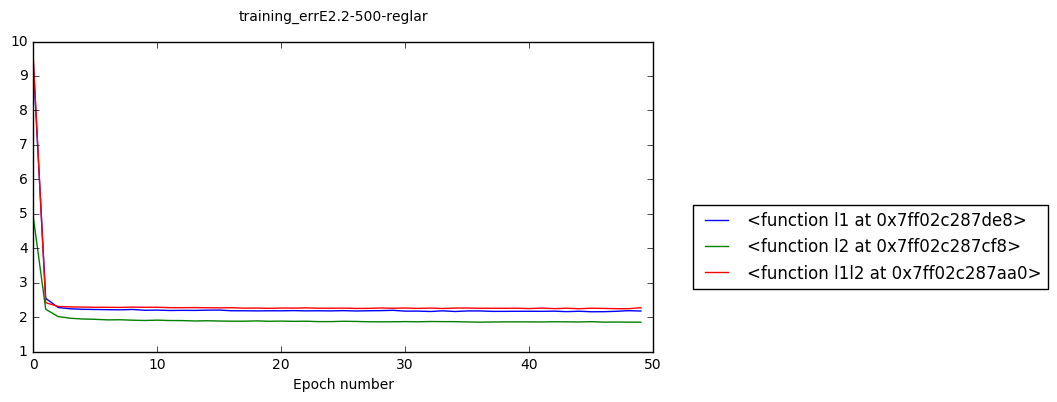

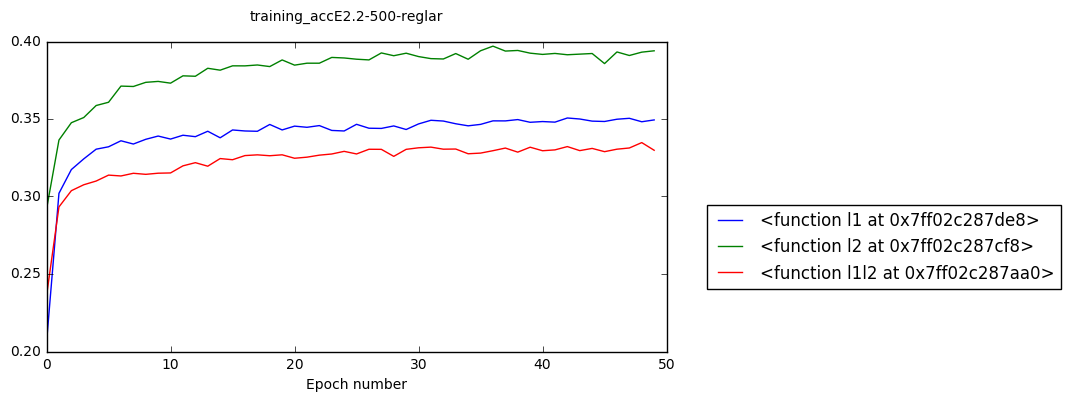

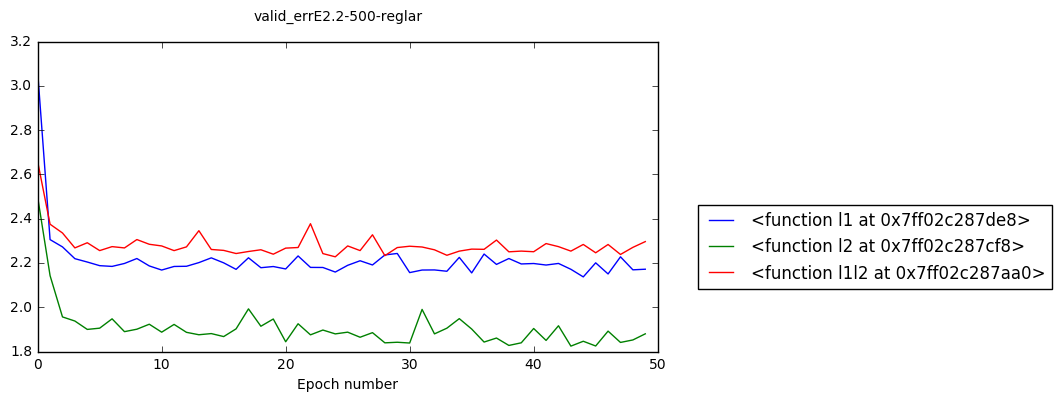

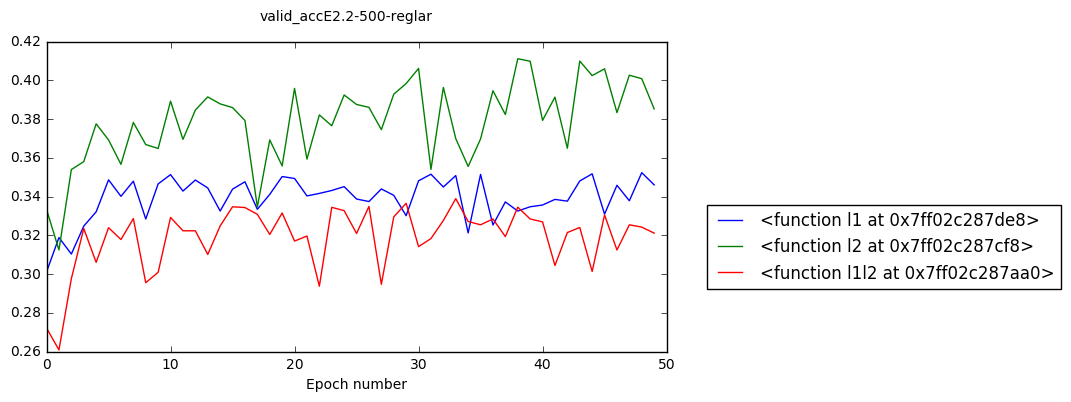

In [22]:
#
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in range(loop):
    ax_1.plot(running_error_[k], label=regulars[k])
ax_1.legend(bbox_to_anchor=(1.65, 0.5))
ax_1.set_xlabel('Epoch number')

fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)

for k in range(loop):
    ax_2.plot(running_accuracy_[k], label=regulars[k])
ax_2.legend(bbox_to_anchor=(1.65, 0.5))
ax_2.set_xlabel('Epoch number')

fig_3 = plt.figure(figsize=(8, 4))
ax_3 = fig_3.add_subplot(111)
for k in range(loop):
    ax_3.plot(valid_error_[k], label=regulars[k])
    
ax_3.legend(bbox_to_anchor=(1.65, 0.5))
ax_3.set_xlabel('Epoch number')

fig_4 = plt.figure(figsize=(8, 4))
ax_4 = fig_4.add_subplot(111)
for k in range(loop):
    ax_4.plot(valid_accuracy_[k], label=regulars[k])
    
# ax_4.legend(loc=0)
ax_4.set_xlabel('Epoch number')
ax_4.legend(bbox_to_anchor=(1.65, 0.5))

fig_1.suptitle("training_errE2.2-500-reglar")
fig_1.savefig("training_errE2.2-500-reglar.png")
fig_2.suptitle("training_accE2.2-500-reglar")
fig_2.savefig("training_accE2.2-500-reglar.png")
fig_3.suptitle("valid_errE2.2-500-reglar")
fig_3.savefig("valid_errE2.2-500-reglar.png")
fig_4.suptitle("valid_accE2.2-500-reglar")
fig_4.savefig("valid_accE2.2-500-reglar.png")

plt.show()

### CIFAR-100

In [ ]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

In [ ]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
num_hidden = 200

with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
    
init = tf.global_variables_initializer()

In [ ]:
sess = tf.Session()
sess.run(init)
for e in range(10):
    running_error = 0.
    running_accuracy = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        running_error += batch_error
        running_accuracy += batch_acc
    running_error /= train_data.num_batches
    running_accuracy /= train_data.num_batches
    print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
          .format(e + 1, running_error, running_accuracy))
    if (e + 1) % 5 == 0:
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
        print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
               .format(valid_error, valid_accuracy))

## Predicting test data classes and creating a Kaggle submission file

An optional [Kaggle in Class](https://inclass.kaggle.com/c/ml2016-7-cifar-100) competition (see email for invite link, you will need to sign-up with a `ed.ac.uk` email address to be able to enter) is being run on the CIFAR-100 (fine-grained) classification task. The scores for the competition are calculated by calculating the proportion of classes correctly predicted on the test set inputs (for which no class labels are provided). Half of the 10000 test inputs are used to calculate a public leaderboard score which will be visible while the competition is in progress and the other half are used to compute the private leaderboard score which will only be unveiled at the end of the competition. Each entrant can make up to two submissions of predictions each day during the competition.

The code and helper function below illustrate how to use the predicted outputs of the TensorFlow network model we just trained to create a submission file which can be uploaded to Kaggle. The required format of the submission file is a `.csv` (Comma Separated Variable) file with two columns: the first is the integer index of the test input in the array in the provided data file (i.e. first row 0, second row 1 and so on) and the second column the corresponding predicted class label as an integer between 0 and 99 inclusive. The predictions must be preceded by a header line as in the following example

```
Id,Class
0,81
1,35
2,12
...
```

Integer class label predictions can be computed from the class probability outputs of the model by performing an `argmax` operation along the last dimension.

In [ ]:
test_inputs = np.load(os.path.join(os.environ['MLP_DATA_DIR'], 'cifar-100-test-inputs.npz'))['inputs']
test_predictions = sess.run(tf.nn.softmax(outputs), feed_dict={inputs: test_inputs})

In [ ]:
def create_kaggle_submission_file(predictions, output_file, overwrite=False):
    if predictions.shape != (10000, 100):
        raise ValueError('predictions should be an array of shape (10000, 25).')
    if not (np.all(predictions >= 0.) and 
            np.all(predictions <= 1.)):
        raise ValueError('predictions should be an array of probabilities in [0, 1].')
    if not np.allclose(predictions.sum(-1), 1):
        raise ValueError('predictions rows should sum to one.')
    if os.path.exists(output_file) and not overwrite:
        raise ValueError('File already exists at {0}'.format(output_file))
    pred_classes = predictions.argmax(-1)
    ids = np.arange(pred_classes.shape[0])
    np.savetxt(output_file, np.column_stack([ids, pred_classes]), fmt='%d',
               delimiter=',', header='Id,Class', comments='')

In [ ]:
create_kaggle_submission_file(test_predictions, 'cifar-100-example-network-submission.csv', True)